In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc
import uncertainties as unc
import pandas as pd
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from uncertainties import unumpy as unp
from uncertainties.unumpy import (nominal_values as noms,
                                  std_devs as stds)

%matplotlib inline
mpl.rcParams['figure.dpi']= 300

read in data

In [2]:
def read_in(path_to_file):
    counts = np.genfromtxt(path_to_file, skip_header = 12,skip_footer = 14, unpack = True)
    df = pd.DataFrame({"channel": np.arange(0,len(counts)), "counts": counts})
    return df

In [3]:
df_Ba = read_in("../data/133Ba.Spe")
df_Cs = read_in("../data/137Cs.Spe")
df_Eu = read_in("../data/152Eu.Spe")
df_U = read_in("../data/Uran.Spe")

In [4]:
for i in [df_Ba,df_Cs,df_Eu,df_U]:
    i["counts"] = unp.uarray(i["counts"], np.sqrt(i["counts"]))

In [5]:
def measure_time(path_to_file):
    f = open(path_to_file)
    lines = f.readlines(200)
    measured_time = lines[9].split()
    return float(measured_time[1])
Ba_measure_time = measure_time("../data/133Ba.Spe")
Cs_measure_time = measure_time("../data/137Cs.Spe")
Eu_measure_time = measure_time("../data/152Eu.Spe")
U_measure_time = measure_time("../data/Uran.Spe")


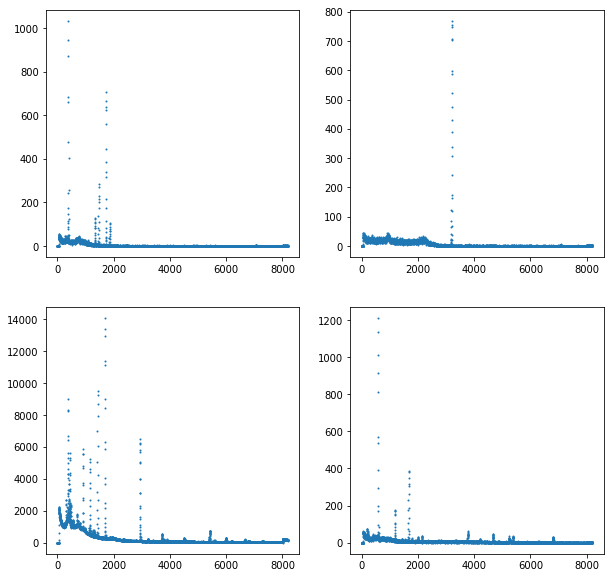

In [6]:
fig,axes = plt.subplots(2,2,figsize = (10,10))
ax_list = axes.flatten()
for ax,df in zip(ax_list.flat,[df_Ba,df_Cs,df_U,df_Eu]):
    ax.scatter(df["channel"], noms(df["counts"]),s=1)


# Kalibrierung mittels 152Eu


In [7]:
plt.clf()
Eu_energy, Eu_prop = np.genfromtxt("../data/Eu_gamma.txt", skip_header = 1, unpack = True)

<Figure size 432x288 with 0 Axes>

In [8]:
peaks = find_peaks(noms(df_Eu["counts"]),prominence = 30)
peaks

(array([  64,  200,  226,  412,  595, 1187, 1668, 2152, 3768, 4661, 5249,
        5376, 6806, 6808]),
 {'prominences': array([  42.,   65.,   47.,   30., 1212.,  170.,  384.,   35.,   65.,
           45.,   37.,   36.,   31.,   31.]),
  'left_bases': array([  51,   51,  211,  331,   51, 1172, 1499, 2135, 3713, 4639, 5233,
         5357, 6785, 6785]),
  'right_bases': array([ 149,  266,  266,  470, 1891, 1414, 1891, 2287, 3789, 4681, 5293,
         5396, 6827, 6827])})

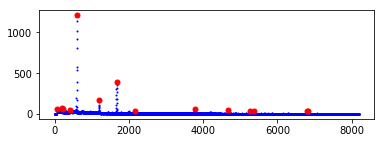

In [9]:
fig,ax = plt.subplots(figsize = (6,2))
ax.scatter(df_Eu["channel"], noms(df_Eu["counts"]),s =1, color = "blue")
ax.plot(peaks[0], noms(df_Eu["counts"])[peaks[0]], linestyle = "", marker= "o", markersize = 5, color = "red")

[]

<Figure size 432x288 with 0 Axes>

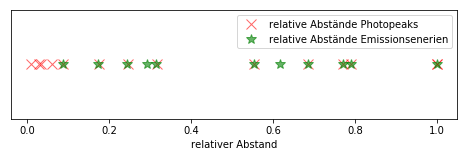

In [10]:
plt.clf()
fig,ax = plt.subplots(figsize = (8,2))
ax.plot(peaks[0]/max(peaks[0]), np.zeros(len(peaks[0])), linestyle = "", marker = "x", markersize = 10, color = "red",alpha = 0.6, label = r"relative Abstände Photopeaks")
ax.plot(Eu_energy/max(Eu_energy), np.zeros(len(Eu_energy)), linestyle = "", marker = "*", markersize = 10, color = "green",alpha = 0.6, label = r"relative Abstände Emissionsenerien")
ax.legend()
ax.set_xlabel("relativer Abstand")
ax.set_yticks([])

In [11]:
Kalibration = pd.DataFrame({"channel": np.take(peaks[0],[4,5,6,7,8,9,10,11,12]) , "energy": np.take(Eu_energy,[0,1,2,4,5,7,8,9,10]),"emission_prop": np.take(Eu_prop,[0,1,2,4,5,7,8,9,10]) })
Kalibration["peak_height"]=df_Eu["counts"][Kalibration["channel"]].values
Kalibration

,channel,energy,emission_prop,peak_height
0,595,121.78,28.60,1212+/-35
1,1187,244.70,7.60,175+/-13
2,1668,344.30,26.50,385+/-20
3,2152,443.96,3.01,35+/-6
4,3768,778.90,12.90,65+/-8
5,4661,964.08,14.60,45+/-7
6,5249,1085.90,10.20,37+/-6
7,5376,1112.10,13.60,36+/-6
8,6806,1408.00,21.00,31+/-6


In [12]:
def lin_reg(x,m,b):
    return m*x + b
params_lin_reg, cov = curve_fit(lin_reg, Kalibration["channel"], Kalibration["energy"])
errors_lin_reg = np.sqrt(np.diag(cov))
x_reg = np.linspace(0,7000,1000)

def channel_kal(channels):
    return params_lin_reg[0]*channels + params_lin_reg[1]

Kalibration: 0.20709759595926713+- 3.5550027861183335e-05 * x + -1.3316182361024969+-0.1441001675927655


<Figure size 432x288 with 0 Axes>

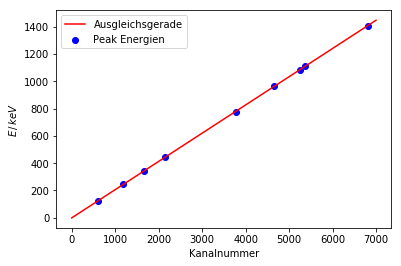

In [13]:
plt.clf()
fig,ax = plt.subplots()
ax.scatter(Kalibration["channel"], Kalibration["energy"], color = "blue", label = r"Peak Energien" )
ax.plot(x_reg,lin_reg(x_reg, *params_lin_reg), color = "red", label = r"Ausgleichsgerade")
ax.set_ylabel(r"$E \, / \,  keV$")
ax.set_xlabel(r"Kanalnummer")
ax.legend()
plt.savefig("../Plots/Channel_Kalibration.pdf" , bbox_inches ="tight")
print(f"Kalibration: {params_lin_reg[0]}+- {errors_lin_reg[0]} * x + {params_lin_reg[1]}+-{errors_lin_reg[1]}")

<Figure size 432x288 with 0 Axes>

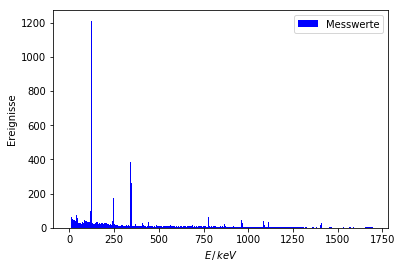

In [14]:
plt.clf()
fig,ax = plt.subplots(figsize = (6,4))
ax.bar(channel_kal(df_Eu["channel"]), noms(df_Eu["counts"]),color = "blue", width = 5,label = r"Messwerte")
#ax.scatter(channel_kal(df_Eu["channel"]), noms(df_Eu["counts"]),s=1)
#ax.set_yscale("log")
ax.set_xlabel(r"$E \, / \, keV$")
ax.set_ylabel(r"Ereignisse")
ax.legend(loc = "best")
plt.savefig("../Plots/Eu_Spektrum.pdf", bbox_inches="tight")


# Aktivität 152Eu##

Abstand Detektor Quelle = 6cm

In [15]:
plt.clf()
from uncertainties import ufloat
from uncertainties.umath import *

<Figure size 432x288 with 0 Axes>

In [16]:
A0 = ufloat(4130,60)
def act(t, T_half,A0 = ufloat(4130,60)):
    return A0 * np.exp(- t * np.log(2) / T_half)

Halbwertszeit: 13 Jahre 196 Tagehttp://www.periodensystem-online.de/index.php?id=isotope&el=63&mz=152&show=nuklid&sel=

In [17]:
##### zeit von 2000 bis Versuchstag und halbwertszeit in s
import datetime
days_gone = datetime.date(year = 2019, month = 11, day =7) - datetime.date(year = 2000, month = 10, day = 1)
seconds_gone = days_gone.total_seconds()
halftime = (13 * 365 + 196) * 24*60*60

In [18]:
activity = act(seconds_gone, halftime)
r = 7.5e-2 ### 6cm abstand + 1.5cm Detektorhaube


# Raumwinkel und gesamte Quanten durch Detektor


In [19]:
kegelwinkel = 2* np.arctan((45e-3)*0.5/r)
raumwinkel = 2 * np.pi * (1-np.cos(kegelwinkel))
N_det = activity * raumwinkel/(4*np.pi) * Eu_measure_time #anzahl gamma quanten,die während der gesamten Messung in detektor fliegen
print(raumwinkel)
print(N_det)

1.0375902342131427
(2.371+/-0.034)e+05


# Peak Inhalte bestimmen und Effizienz berechnen

In [20]:
def peak_intensity(df_cal, df_data):  ######## bestimmung der Signale in den Peaks, hier alle werte in den umliegenden 20 kanälen 
    x,y = [],[]
    peak_sum = []
    for channel in df_cal["channel"].values:
        peak_sum_i = []
        for i in range(channel-10,channel+10):
            x.append(i)
            y.append(df_data["counts"][i])
            peak_sum_i.append(df_data["counts"][i])
        peak_sum.append(sum(peak_sum_i))
    return peak_sum,np.array(x),np.array(y)

In [21]:
Kalibration["peak_sum"] = peak_intensity(Kalibration, df_Eu)[0]
Kalibration["efficiency"] = Kalibration["peak_sum"] / (N_det * Kalibration["emission_prop"]/100) #### wahrscheinlichkeit ist in prozent im df
Kalibration

,channel,energy,emission_prop,peak_height,peak_sum,efficiency
0,595,121.78,28.60,1212+/-35,(7.69+/-0.09)e+03,0.1134+/-0.0021
1,1187,244.70,7.60,175+/-13,(1.42+/-0.04)e+03,0.0785+/-0.0024
2,1668,344.30,26.50,385+/-20,(3.11+/-0.06)e+03,0.0496+/-0.0011
3,2152,443.96,3.01,35+/-6,346+/-19,0.0485+/-0.0027
4,3768,778.90,12.90,65+/-8,643+/-25,0.0210+/-0.0009
5,4661,964.08,14.60,45+/-7,536+/-23,0.0155+/-0.0007
6,5249,1085.90,10.20,37+/-6,355+/-19,0.0147+/-0.0008
7,5376,1112.10,13.60,36+/-6,435+/-21,0.0135+/-0.0007
8,6806,1408.00,21.00,31+/-6,417+/-20,0.0084+/-0.0004


Ausgleichsrechnung Effizienz

In [22]:
def Effizienz(E,a,b,):
    return a * E**b 

params_eff, cov = curve_fit(Effizienz, Kalibration["energy"], noms(Kalibration["efficiency"]))
errors_eff = np.sqrt(np.diag(cov))
unc_eff = np.array([ufloat(params_eff[0],errors_eff[0]),ufloat(params_eff[1],errors_eff[1])])


6.903289809252806 -0.8451820870333334 2.6724519485210094 0.07276084019892619


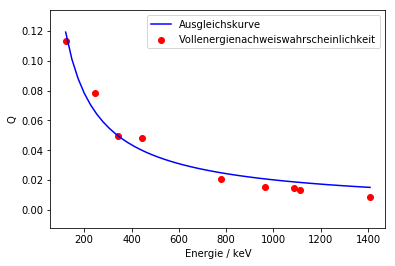

In [23]:
x_eff = np.linspace(min(Kalibration["energy"]),max(Kalibration["energy"]))
fig,ax = plt.subplots(figsize = (6,4))
ax.scatter(Kalibration["energy"],noms(Kalibration["efficiency"]),c = "red", label = r"Vollenergienachweiswahrscheinlichkeit" )
ax.plot(x_eff, Effizienz(x_eff,*params_eff),c = "blue", label = "Ausgleichskurve")
#ax.fill_between(x_eff, fit(x_eff,*params_eff-errors_eff), fit(x_eff,*params_eff+errors_eff),alpha = 0.2)
ax.set_xlabel(r"Energie / keV")
ax.set_ylabel(r"Q")
ax.legend(loc= "best")
plt.savefig("../Plots/Effizienz.pdf", bboc_inches = "tight")

print(*params_eff, *errors_eff)

# 137Cs

In [35]:
Cs_measure_time = measure_time("../data/137Cs.Spe")
df_Cs["energy"] = channel_kal(df_Cs["channel"])
df_Cs = df_Cs[df_Cs["energy"] < 750] ### uns interessiert nur alles bis zum photopeak

In [ ]:
plt.clf()
fig,ax = plt.subplots(figsize = (6,4))
ax.bar(channel_kal(df_Cs["channel"]), noms(df_Cs["counts"]),color = "blue", width = 4, label = r"Messwerte")
#ax.scatter(channel_kal(df_Eu["channel"]), noms(df_Eu["counts"]),s=1)
#ax.set_yscale("log")
ax.set_xlabel(r"$E \, / \, keV$")
ax.set_ylabel(r"Ereignisse")
ax.legend(loc="best")
plt.savefig("../Plots/Cs_Spektrum.pdf", bbox_inches="tight")

## Auswertung des Photopeaks

In [36]:
df_PP = df_Cs[df_Cs['energy'].between(657, 665)] ###### wir betrachten nur Photopeak

def gaus(E,a,E0,sigma):
    return a*np.exp(-(E-E0)**2/(2*sigma**2))

params_gaus, cov = curve_fit(gaus, df_PP["energy"], noms(df_PP["counts"]), p0 = [1,661.5,1])
errors_gaus = np.sqrt(np.diag(cov))
x_fit = np.linspace(min(df_PP["energy"]), max(df_PP["energy"]), 1000)

Amp = ufloat(params_gaus[0],errors_gaus[0])
E0 = ufloat(params_gaus[1],errors_gaus[1])
sigma = ufloat(params_gaus[2], errors_gaus[2])

FWHM = 2 * np.sqrt(2*np.log(2)) * sigma
FWTM = 2 * np.sqrt(2*np.log(10)) * sigma
peak_inhalt = sum(df_PP["counts"])

half_width = [min(x_fit[gaus(x_fit,*params_gaus) >= Amp/2]), max(x_fit[gaus(x_fit,*params_gaus) >= Amp/2])]
tenth_width = [min(x_fit[gaus(x_fit,*params_gaus) >= Amp/10]), max(x_fit[gaus(x_fit,*params_gaus) >= Amp/10])]


print(half_width)
print(tenth_width)
print("Breiten",FWHM,FWTM)
print("Amplitude", Amp)
print("Emissionsenergie",E0)
print("sigma", sigma)
print("Peak Inhalt",peak_inhalt)



[660.6710841579081, 662.8216651994311]
[659.7887944998474, 663.7118324437245]
Breiten 2.158+/-0.022 3.93+/-0.04
Amplitude 767+/-7
Emissionsenergie 661.749+/-0.009
sigma 0.916+/-0.009
Peak Inhalt (8.61+/-0.09)e+03


<Figure size 432x288 with 0 Axes>

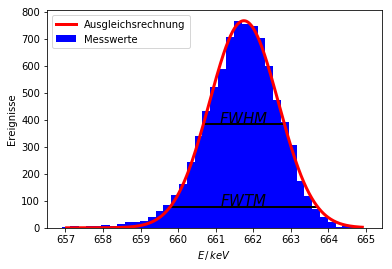

In [27]:
plt.clf()
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(x_fit, gaus(x_fit, *params_gaus),color = "red",linewidth = 3, label = r"Ausgleichsrechnung")
#ax.scatter(df_PP["energy"], noms(df_PP["counts"]),c = "dodgerblue", label = r"Messwerte")
ax.bar(df_PP["energy"], noms(df_PP["counts"]),width = 0.23,align = "center",color = "blue", label = r"Messwerte")
ax.set_xlabel(r"$E \,/\, keV$")
ax.set_ylabel(r"Ereignisse")
ax.legend(loc = "best")
ax.hlines(noms(Amp/2),half_width[0],half_width[1],linewidth = 2)
ax.text(noms(E0),noms(Amp/2)+4, r"$FWHM$",horizontalalignment='center', fontsize = 15)
ax.hlines(noms(Amp/10), tenth_width[0], tenth_width[1],linewidth = 2)
ax.text(noms(E0),noms(Amp/10)+4, r"$FWTM$",horizontalalignment='center', fontsize = 15)
plt.savefig("../Plots/Cs_Photopeak.pdf", bbox_inches = "tight")

# Comptonkontinuum von 137Cs

In [37]:
df_com = df_Cs[df_Cs['energy'].between(0, 510)] ###### wir betrachten nur Compton Continuum
df_back = df_com[df_com["energy"].between(150,250)]
df_kante = df_com[df_com["energy"].between(420,480)]

def gaus(E,a,E0,sigma,c):
    return a*np.exp(-(E-E0)**2/(2*sigma**2)) +c

params_backscat, cov = curve_fit(gaus,df_back["energy"],noms(df_back["counts"]) , p0 = [40,190,1,1])
errors_backscat = np.sqrt(np.diag(cov))
x_back = np.linspace(180,210,1000)
energy_backscat = ufloat(params_backscat[1],errors_backscat[1])

compton_inhalt = sum(df_com["counts"][df_com["energy"].between(100,480)])

print("compton inhalt", compton_inhalt)
print("Comptonkante bei 470 +- 5kev")
print("Rückstreupeak bei 190 +- 5keV")

compton inhalt (3.144+/-0.018)e+04
Comptonkante bei 470 +- 5kev
Rückstreupeak bei 190 +- 5keV


<Figure size 432x288 with 0 Axes>

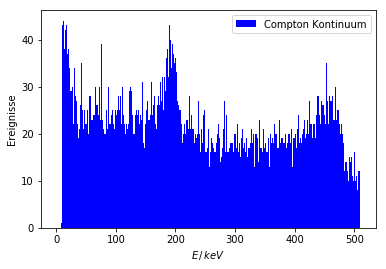

In [29]:
plt.clf()
fig,ax = plt.subplots(figsize = (6,4))
ax.bar(df_com["energy"], noms(df_com["counts"]),width = 0.8+0.22,align = "center",color = "blue", label = r"Compton Kontinuum")
ax.set_xlabel(r"$E \,/\, keV$")
ax.set_ylabel(r"Ereignisse")
ax.legend(loc = "best")
plt.savefig("../Plots/Cs_Comptonkontiuum.pdf", bbox_inches = "tight")


In [38]:
### theoriewerte für comptionkante und rückstreupeak
import scipy.constants as cons
E = 662 #ev
e = E / 511 ### ruheenergie elektron 511keV
E_max = E * 2*e/(1+2*e)
E_back = E * 1/(1+2*e)

print(f"Compton-Kante = {E_max}")
print(f"Rückstreupeak = {E_back}")


Compton-Kante = 477.65013623978206
Rückstreupeak = 184.34986376021797


In [39]:
mu_ph = 0.01 #in 1/cm ### https://physics.nist.gov/cgi-bin/Xcom/xcom3_1
mu_com = 0.36 ### https://physics.nist.gov/cgi-bin/Xcom/xcom3_1

d_det = 3.9

def WW_prop(mu,d):
    return 1-np.exp(-mu*d)
W_ph = WW_prop(mu_ph,d_det)
W_com = WW_prop(mu_com,d_det)

print(f"Wahrscheinlichkeit Photoabsorption = {W_ph}")
print(f"Wahrscheinlichkeit Comptonabsorption = {W_com}")

V_prop = W_ph/W_com
V_counts = peak_inhalt/compton_inhalt

print(f"Verhältnis wahrscheinlichkeit Photo zu Compton = {V_prop}")
print(f"Verhältnis counts Photo zu Comption = {1/V_counts}")

Wahrscheinlichkeit Photoabsorption = 0.038249290853633267
Wahrscheinlichkeit Comptonabsorption = 0.7543874537661878
Verhältnis wahrscheinlichkeit Photo zu Compton = 0.05070244827466089
Verhältnis counts Photo zu Comption = 3.65+/-0.04


# Aktivitätenbestimmung Ba

In [40]:
channels = np.array([398,1342,1469,1725,1860]) ###channels der peaks
df_Ba["energy"] = channel_kal(df_Ba["channel"])


Ba_peaks = []
Ba_Ndet = []
for U in channels:
    E = channel_kal(U)
    Ba_peaks.append(E)
    Ba_Ndet.append(sum(df_Ba["counts"][df_Ba["energy"].between(E-2.5,E+2.5)]/Effizienz(E,*unc_eff)))


activity_Ba = sum(Ba_Ndet / (Ba_measure_time*raumwinkel/(4*np.pi)))    
print(activity_Ba)   
print(Ba_peaks)
    


(1.3+/-0.7)e+03
[81.09322495568581, 276.593355541234, 302.89475022806096, 355.91173479363334, 383.8699102481344]


In [33]:
A0 = ufloat(4130,60)
def act(t, T_half,A0 = ufloat(4130,60)):
    return A0 * np.exp(- t * np.log(2) / T_half)

days_gone = datetime.date(year = 2019, month = 11, day =7) - datetime.date(year = 2000, month = 10, day = 1)
seconds_gone = days_gone.total_seconds()
halftime = (10 * 365 + 188) * 24*60*60
Ba_activity = act(seconds_gone,halftime,4000)
Ba_activity

1134.7595734736617

KeyboardInterrupt: 

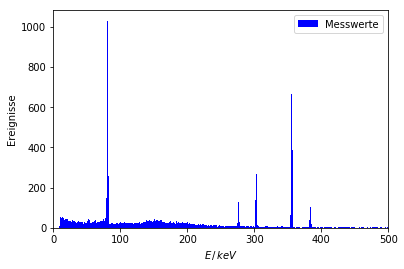

In [34]:
fit,ax = plt.subplots(figsize = (6,4))
#ax.scatter(channel_kal(df_Ba["channel"]),noms(df_Ba["counts"]),s=1)
ax.bar(df_Ba["energy"], noms(df_Ba["counts"]),width = 1, color = "blue",label = r"Messwerte")
ax.set_xlabel(r"$E \,/\, keV$")
ax.set_ylabel(r"Ereignisse")
ax.set_xlim(0,500)
ax.legend(loc = "best")
plt.savefig("../Plots/Ba_Spektrum.pdf",bbox_inches = "tight")

# Untersuchung Unbekannter Strahler

In [ ]:
df_U["energy"] = channel_kal(df_U["channel"])
peaks = np.array([382,315,432,456,549,708,754,800,910,1176,1254,1318,1435,1708,2952,3225,3717,3818,3903,4065,4522,4854,5419,5597,5985,6200,6659,6812,7284])
peak_energies = channel_kal(peaks)
print(peak_energies)
U_energies = np.array([187,241.5,295.2,351.9,609,1120,768,1237,1377])## http://nucleardata.nuclear.lu.se/toi/Gamma.asp?sql=&Min=1237&Max=1239
U_isotops = np.array(["226Ra","214Pb","214Pb","214Pb","214Bi","210Bi", "214Bi","214Bi","214Bi"])
U_peakheight = []
U_Ndet = []
for E in U_energies:
    U_peakheight.append(noms(max(df_U["counts"][df_U["energy"].between(E-2.5,E+2.5)])))
    U_Ndet.append(sum(df_U["counts"][df_U["energy"].between(E-2.5,E+2.5)])/Effizienz(E,*unc_eff)) ####### Alle beobachteten Peaks haben in etwa eine Breite von 5kev
act_U = sum( U_Ndet/ (U_measure_time * raumwinkel/(4*np.pi)))
print(act_U) 
df_isotops = pd.DataFrame({"energy":U_energies,"isotop":U_isotops})
print(df_isotops)



In [ ]:
plt.clf()
fig,ax = plt.subplots(figsize = (10,6))
ax.plot(df_U["energy"], noms(df_U["counts"]),linewidth = 1, color = "blue")
#ax.scatter(df_U["energy"][baba[0]], noms(df_U["counts"][baba[0]]), color = "red")
#ax.bar(df_U["energy"], noms(df_U["counts"]),width = 5, color = "blue",label =r"Messwerte")
for e,h,i in zip(U_energies,U_peakheight,U_isotops):
    ax.text(e,h,i,color="red", fontsize = 9)
ax.set_xlabel(r"$E \,/\, keV$")
ax.set_ylabel(r"Ereignisse")
ax.legend(loc = "best")
#plt.savefig("../Plots/U_Spektrum.pdf", bboc_inches = "tigth")